## Proyecto Final
### Machine Learning Avanzado

### Alejandro Hernández Rodríguez

#### Automatización de compra y venta de acciones utilizando algoritmos de aprendizaje por refuerzo

Descargar biblioteca finrl. En la página oficial describren lo siguiente:

" FinRL is an open source library that provides practitioners a unified framework for pipeline strategy development. In reinforcement learning (or Deep RL), an agent learns by continuously interacting with an environment, in a trial-and-error manner, making sequential decisions under uncertainty and achieving a balance between exploration and exploitation. The open source community AI4Finance (to efficiently automate trading) provides educational resources about deep reinforcement learning (DRL) in quantitative finance."


FinRL es una biblioteca de código abierto que provee a practicantes un marco unificado para el desarrollo de estrategia. En aprendizaje por refuerzo, un agente aprende a partir de interactuar continuamente con un entorno, en una forma prueba-error, tomando decisiones secuenciales bajo incertidumbre y alcanzando el balance entre exploración y explotación.

In [1]:
import yfinance as yf 


In [2]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-u322g66e
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-ugagqh5g/pyfolio_1228268731854a4481b34f179547bd46
  Created wheel for finrl: filename=finrl-0.3.0-py3-none-any.whl size=38677 sha256=d1c8ee8417113a8e0f9104377d1c2f90f371ed3d7651dd0c0a97d225d9e7b1b1
  Stored in directory: /tmp/pip-ephem-wheel-cache-s6igtfkc/wheels/49/3d/1f/c9536878bb675d170193de014feb2a1b11d93d87929560ce55
Successfully built finrl


In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_stocktrading import StockTradingEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import backtest_stats, backtest_plot, get_daily_return, get_baseline

import sys
sys.path.append("../FinRL-Library")

import itertools


/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [4]:
import yfinance as yf 

def fetch_data(start_date, end_date, ticker_list) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------

        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        for tic in ticker_list:
            temp_df = yf.download(tic, start=start_date, end=end_date)
            print('here')


            temp_df["tic"] = tic
            data_df = data_df.append(temp_df)
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.columns = [
                "date",
                "open",
                "high",
                "low",
                "close",
                "adjcp",
                "volume",
                "tic",
            ]
            # use adjusted close price instead of close price
            data_df["close"] = data_df["adjcp"]
            # drop the adjusted close price column
            data_df = data_df.drop("adjcp", 1)
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=['date','tic']).reset_index(drop=True)

        return data_df

In [5]:
# Utilizaré las stocks que pertenecen al indice NASDAQ 

NAS_TICKER = ['AMGN', 'AAPL', 'AMAT', 'INTC', 'PCAR', 'PAYX', 'MSFT', 'ADBE', 'CSCO', 'XLNX', 'QCOM', 'COST', 'SBUX', 'FISV', 'CTXS', 'INTU', 'AMZN', 'EBAY', 'BIIB', 'CHKP', 'GILD', 'NLOK', 'CMCSA', 'FAST', 'ADSK', 'CTSH', 'NVDA', 'GOOGL', 'ISRG', 'VRTX', 'HSIC', 'BIDU', 'ATVI', 'ADP', 'ROST', 'ORLY', 'CERN', 'BKNG', 'MU', 'DLTR', 'ALXN', 'SIRI', 'MNST', 'AVGO', 'TXN', 'MDLZ', 'FB', 'ADI', 'WDC', 'REGN', 'LBTYK', 'VRSK', 'NFLX', 'TSLA', 'CHTR', 'MAR', 'ILMN', 'LRCX', 'EA', 'AAL', 'WBA', 'KHC', 'BMRN', 'JD', 'SWKS', 'INCY', 'PYPL', 'CDW', 'FOXA', 'MXIM', 'TMUS', 'EXPE', 'TCOM', 'ULTA', 'CSX', 'NTES', 'MCHP', 'CTAS', 'KLAC', 'HAS', 'JBHT', 'IDXX', 'WYNN', 'MELI', 'ALGN', 'CDNS', 'WDAY', 'SNPS', 'ASML', 'TTWO', 'PEP', 'NXPI', 'XEL', 'AMD', 'NTAP', 'VRSN', 'LULU', 'WLTW', 'UAL']


# Extracción de 
df = YahooDownloader(start_date = '2010-06-01',
                     end_date = '2021-05-02',
                     ticker_list = NAS_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-06-01,8.640000,8.970000,8.550000,8.145288,9995500,AAL,1
1,2010-06-01,9.274643,9.497857,9.248571,8.010303,876472800,AAPL,1
2,2010-06-01,32.360001,33.040001,32.099998,32.130001,9744400,ADBE,1
3,2010-06-01,28.980000,29.490000,28.750000,21.914240,4551400,ADI,1
4,2010-06-01,35.776997,36.233540,35.434593,26.932873,3194098,ADP,1


Con el método de FeatureEngineer

In [7]:
TECHNICAL_INDICATORS = ['macd', 'rsi_30', 'cci_30', 'dx_30']

fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = TECHNICAL_INDICATORS,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [8]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [9]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2010-06-01,AAL,8.640000,8.970000,8.550000,8.145288,9995500.0,1.0,0.0,100.0,66.666667,100.0,0.0
1,2010-06-01,AAPL,9.274643,9.497857,9.248571,8.010303,876472800.0,1.0,0.0,100.0,66.666667,100.0,0.0
2,2010-06-01,ADBE,32.360001,33.040001,32.099998,32.130001,9744400.0,1.0,0.0,100.0,66.666667,100.0,0.0
3,2010-06-01,ADI,28.980000,29.490000,28.750000,21.914240,4551400.0,1.0,0.0,100.0,66.666667,100.0,0.0
4,2010-06-01,ADP,35.776997,36.233540,35.434593,26.932873,3194098.0,1.0,0.0,100.0,66.666667,100.0,0.0
5,2010-06-01,ADSK,29.010000,29.580000,28.500000,28.559999,4269600.0,1.0,0.0,100.0,66.666667,100.0,0.0
6,2010-06-01,ALGN,14.850000,14.850000,14.210000,14.380000,1673000.0,1.0,0.0,100.0,66.666667,100.0,0.0
7,2010-06-01,ALXN,24.745001,25.165001,24.420000,24.420000,1355400.0,1.0,0.0,100.0,66.666667,100.0,0.0
8,2010-06-01,AMAT,12.830000,13.000000,12.580000,10.205918,20702700.0,1.0,0.0,100.0,66.666667,100.0,0.0
9,2010-06-01,AMD,8.430000,8.430000,8.140000,8.140000,31201200.0,1.0,0.0,100.0,66.666667,100.0,0.0


In [10]:
train = data_split(processed_full, '2010-06-01','2020-05-01')
trade = data_split(processed_full, '2020-06-01','2021-05-01')

In [11]:
train.head(100)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2010-06-01,AAL,8.640000,8.970000,8.550000,8.145288,9995500.0,1.0,0.000000,100.0,66.666667,100.0,0.0
0,2010-06-01,AAPL,9.274643,9.497857,9.248571,8.010303,876472800.0,1.0,0.000000,100.0,66.666667,100.0,0.0
0,2010-06-01,ADBE,32.360001,33.040001,32.099998,32.130001,9744400.0,1.0,0.000000,100.0,66.666667,100.0,0.0
0,2010-06-01,ADI,28.980000,29.490000,28.750000,21.914240,4551400.0,1.0,0.000000,100.0,66.666667,100.0,0.0
0,2010-06-01,ADP,35.776997,36.233540,35.434593,26.932873,3194098.0,1.0,0.000000,100.0,66.666667,100.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2010-06-01,WLTW,80.741722,81.562912,80.238411,63.106480,242317.0,1.0,0.000000,100.0,66.666667,100.0,0.0
0,2010-06-01,WYNN,82.580002,84.879997,81.410004,53.665573,2540900.0,1.0,0.000000,100.0,66.666667,100.0,0.0
0,2010-06-01,XEL,20.309999,20.520000,20.139999,13.599694,1921900.0,1.0,0.000000,100.0,66.666667,100.0,0.0
0,2010-06-01,XLNX,24.230000,24.639999,23.879999,18.927534,6091900.0,1.0,0.000000,100.0,66.666667,100.0,0.0


In [12]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(TECHNICAL_INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")



Stock Dimension: 99, State Space: 595


In [13]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [14]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [15]:
agent = DRLAgent(env = env_train)

In [16]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


/opt/conda/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370116979/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=5000)

Logging to tensorboard_log/a2c/a2c_11
------------------------------------
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 80       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -141     |
|    explained_variance | -0.565   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -127     |
|    std                | 1        |
|    value_loss         | 0.962    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 6        |
|    iterations         | 200      |
|    time_elapsed       | 159      |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -141     |
|    explained_variance | 0.0209   |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |


### Proximal Policy Optimization

In [18]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [19]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=5000)

Logging to tensorboard_log/ppo/ppo_7
-----------------------------
| time/              |      |
|    fps             | 6    |
|    iterations      | 1    |
|    time_elapsed    | 313  |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| environment/            |            |
|    portfolio_value      | 4.82e+06   |
|    total_cost           | 1.16e+06   |
|    total_reward         | 3.82e+06   |
|    total_reward_pct     | 382        |
|    total_trades         | 219763     |
| time/                   |            |
|    fps                  | 6          |
|    iterations           | 2          |
|    time_elapsed         | 661        |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.03090395 |
|    clip_fraction        | 0.427      |
|    clip_range           | 0.2        |
|    entropy_loss         | -141       |
|    explained_variance   | -0.00953   |
|    learning_r

In [20]:
data_turbulence = processed_full[(processed_full.date<'2019-01-01') & (processed_full.date>='2010-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])
insample_turbulence.turbulence.describe()
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)
turbulence_threshold

1516.7785641060382

In [21]:
trade = data_split(processed_full, '2019-01-01','2021-01-01')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 380, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

## Testing 

In [22]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


hit end!
==============Compare to NDX===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,14.091%
Cumulative returns,30.236%
Annual volatility,17.906%
Sharpe ratio,0.83
Calmar ratio,0.94
Stability,0.30
Max drawdown,-14.971%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.97,2020-02-19,2020-03-10,2020-07-06,99
1,13.91,2020-09-02,2020-10-28,NaT,NaN
2,12.04,2019-04-23,2019-06-03,2020-02-18,216
3,5.57,2020-07-20,2020-08-11,2020-08-28,30
4,2.98,2019-03-01,2019-03-08,2019-03-15,11


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


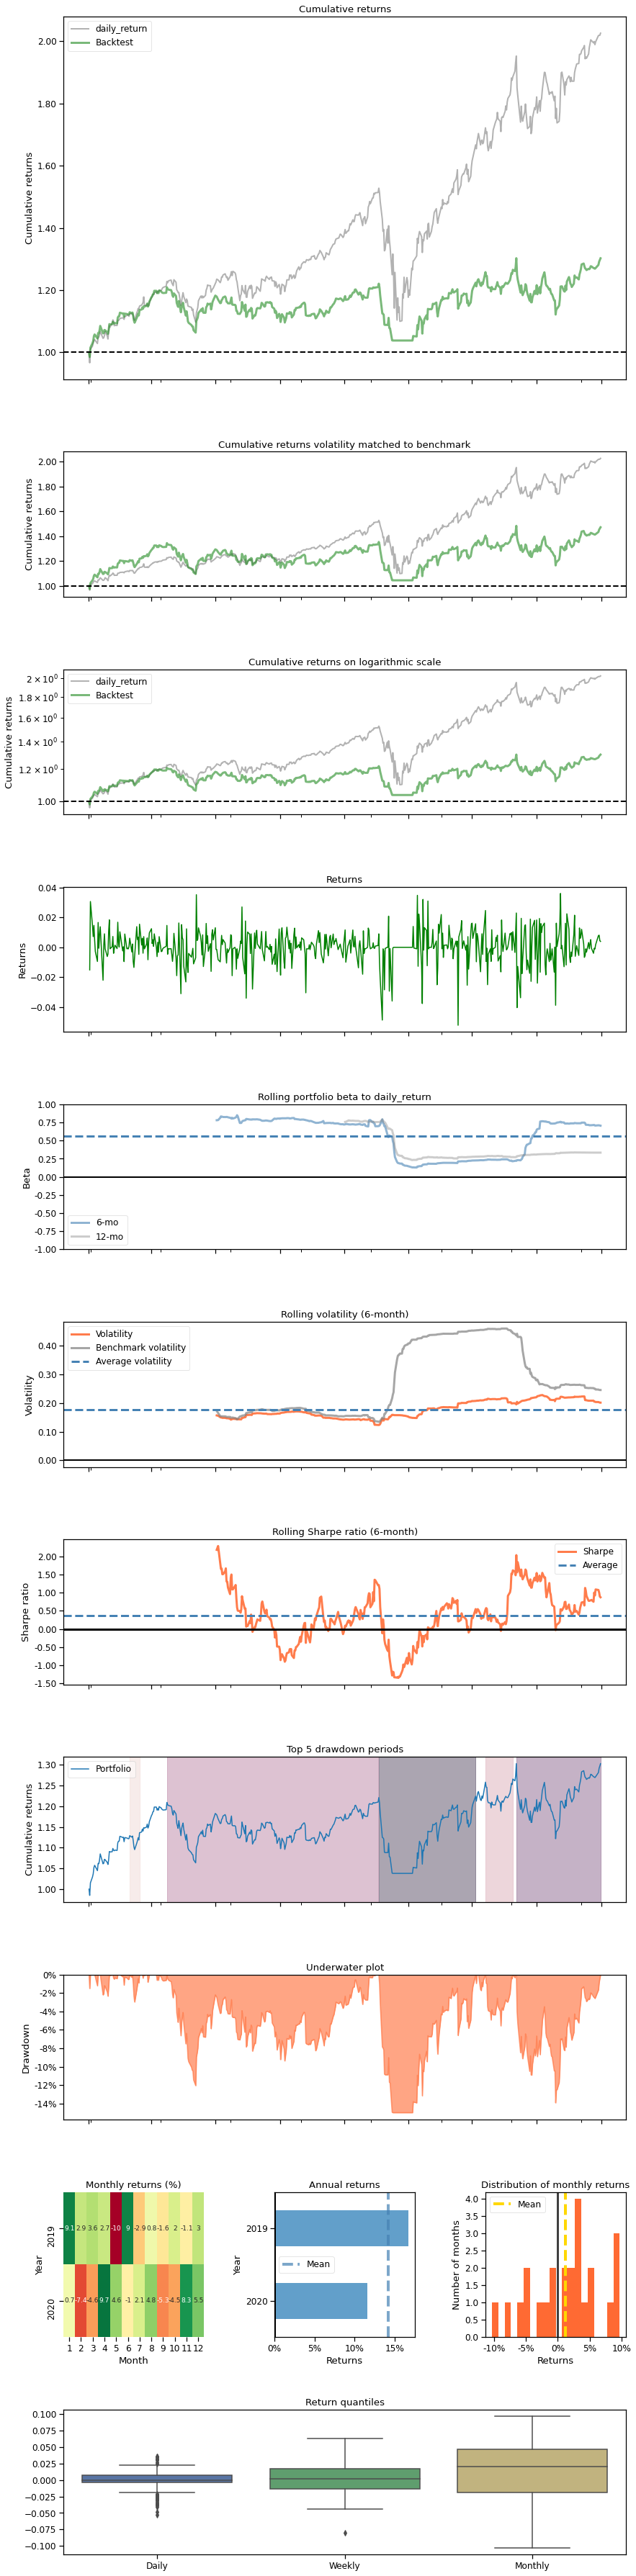

In [23]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

print("==============Compare to NDX===========")
%matplotlib inline

backtest_plot(df_account_value, 
             baseline_ticker = '^NDX', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')

hit end!
==============Compare to NDX===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,11.003%
Cumulative returns,23.267%
Annual volatility,17.594%
Sharpe ratio,0.68
Calmar ratio,0.68
Stability,0.29
Max drawdown,-16.106%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.11,2020-02-19,2020-03-10,2020-07-06,99
1,14.02,2019-04-23,2019-06-03,2020-01-13,190
2,12.29,2020-09-02,2020-09-23,2020-12-04,68
3,5.69,2020-07-10,2020-08-11,2020-08-31,37
4,5.10,2019-02-19,2019-03-08,2019-03-26,26


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


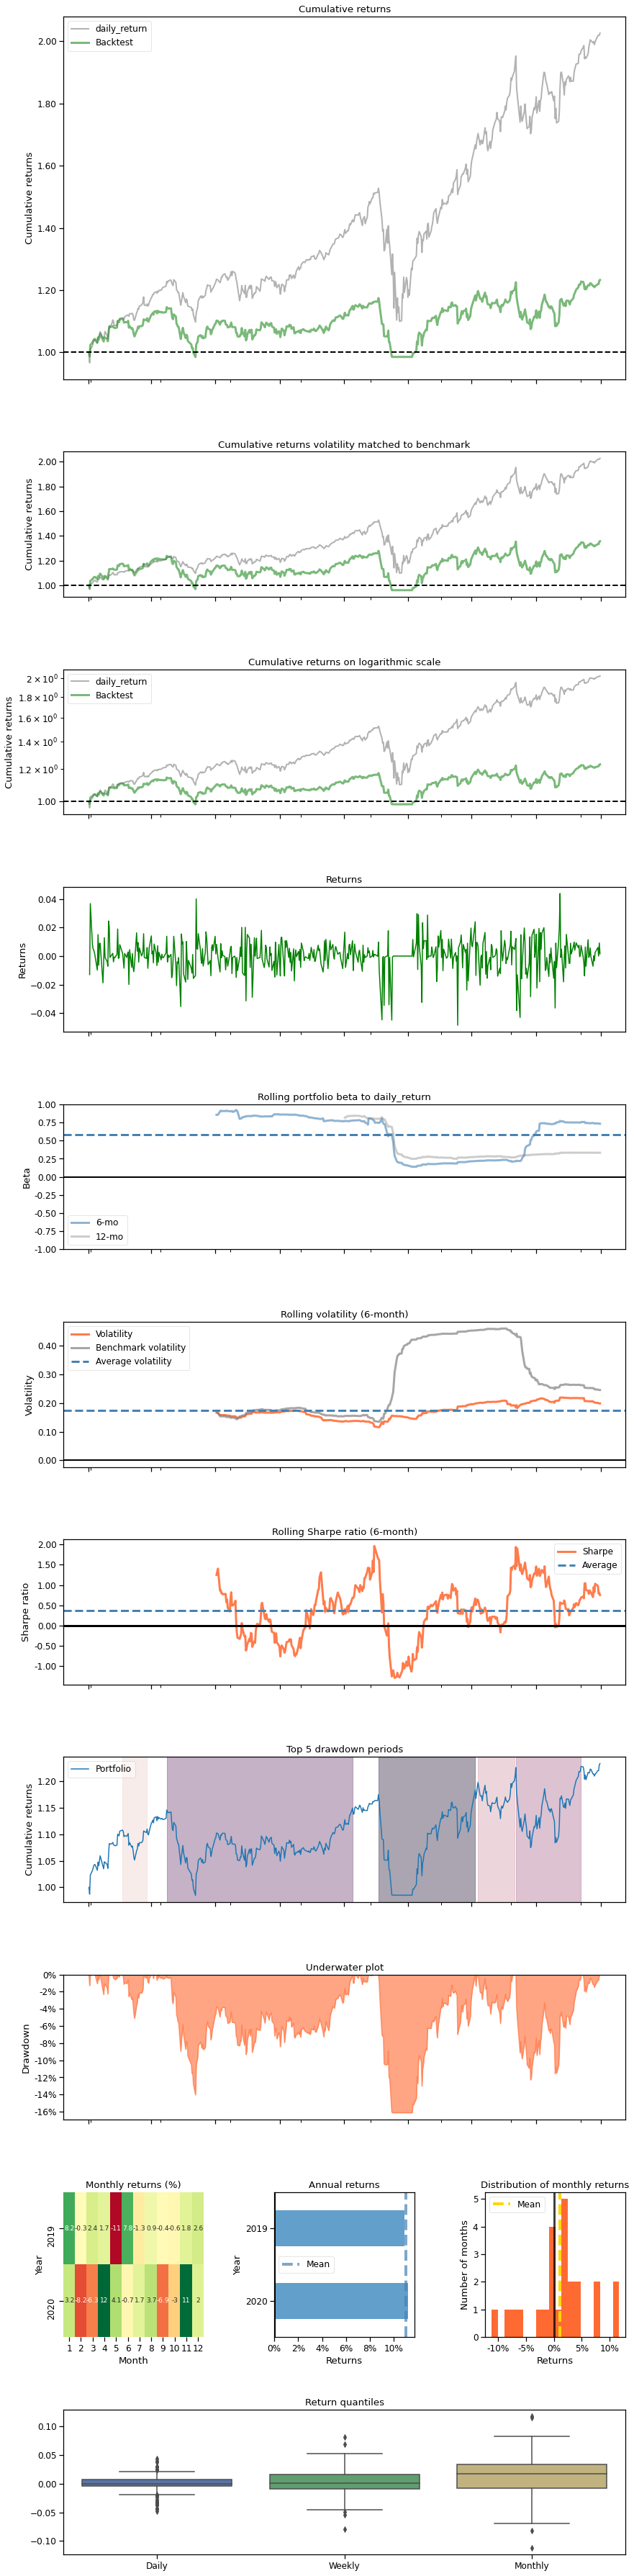

In [24]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

print("==============Compare to NDX===========")
%matplotlib inline

backtest_plot(df_account_value, 
             baseline_ticker = '^NDX', 
             baseline_start = '2019-01-01',
             baseline_end = '2021-01-01')